# Quante persone saranno contagiate?

Si vedono tante proiezioni sui contagiati, tutte fanno vedere una curva esponenziale (che shizza verso l'alto).
Questo effetto piuttosto drammatico è dato più dalla scelta del modello statistico che dai dati in sè.

In questo notebook confrontiamo il modello esponenziale con un modello più sobrio, che tiene conto del più comune andamento dei fenomeni biologici: cioè una rapida crescita seguita da un assestamento. Faremo anche una predizione su quando avverrà questo assestamento.

Per cominciare importiamo le librerie, carichiamo i dati e facciamo una pulizia.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lmfit import Model

df = pd.read_csv('./../publication/riepilogoArchivio.csv')
# df = df.dropna()
df['numero'] = df['CASI TOTALI']
df.head(5)

,Regione,Ricoverati con sintomi,Terapia intensiva,Isolamento domiciliare,Totale attualmente positivi,DIMESSI GUARITI,DECEDUTI,CASI TOTALI,TAMPONI,datetime,aggiornamento,fonte,numero
0,Lombardia,1622.0,309.0,77.0,2008.0,469.0,135.0,2612.0,13556.0,2020-03-06,pomeridiano,http://www.protezionecivile.gov.it/attivita-ri...,2612.0
1,Emilia Romagna,397.0,53.0,366.0,816.0,17.0,37.0,870.0,3136.0,2020-03-06,pomeridiano,http://www.protezionecivile.gov.it/attivita-ri...,870.0
2,Veneto,117.0,27.0,310.0,454.0,22.0,12.0,488.0,13023.0,2020-03-06,pomeridiano,http://www.protezionecivile.gov.it/attivita-ri...,488.0
3,Marche,73.0,20.0,62.0,155.0,NaN,4.0,159.0,585.0,2020-03-06,pomeridiano,http://www.protezionecivile.gov.it/attivita-ri...,159.0
4,Piemonte,57.0,30.0,52.0,139.0,NaN,4.0,143.0,793.0,2020-03-06,pomeridiano,http://www.protezionecivile.gov.it/attivita-ri...,143.0


Prendiamo in esame i malati cumulativi in base ai giorni.

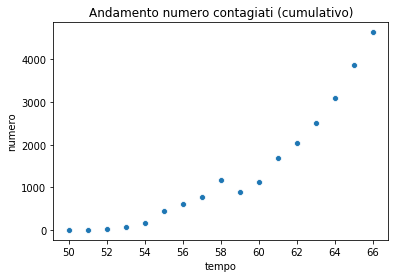

In [2]:
# semplifichiamo le date usando il giorno dell'anno ( da 0 a 365 )
df['tempo'] = df['datetime'].map( lambda d: pd.to_datetime(d).timetuple().tm_yday )

# raggruppa in base al giorno
df_by_datetime = df[ ['datetime', 'tempo', 'numero'] ].groupby('tempo')
df_by_datetime = df_by_datetime.sum().sort_values(by='tempo')
df_by_datetime = df_by_datetime.reset_index()

# contagi cumulativi
g = sns.scatterplot(data=df_by_datetime, x='tempo', y='numero')
g.set_title('Andamento numero contagiati (cumulativo)')
plt.show()

Definiamo quattro modelli diversi
- linea
- potenza
- esponente
- sigmoide

In [3]:
def line(x, a, b, c):
    return x*a + b
line_init_params = { 'a': 2, 'b': 1, 'c':0 }

def power(x, a, b, c):
    return (x**a) * b + c
pow_init_params = { 'a': 2, 'b': 1, 'c':0 }

def exponent(x, a, b, c):
    return (a**x) * b + c
exp_init_params = { 'a': 2, 'b': 10, 'c':0 }

def sigmoid(x, a, b, c):
    expo = a * (b - x)
    sig = 1 / ( 1 + np.exp( expo ) ) * c
    return sig
sig_init_params = { 'a': 0.001, 'b': 500, 'c':4000 }

all_models_and_initial_params = [
    ['lineare', line, line_init_params],
    ['potenza', power, pow_init_params],
    ['esponenziale', exponent, exp_init_params],
    ['sigmoidale', sigmoid, sig_init_params]
]

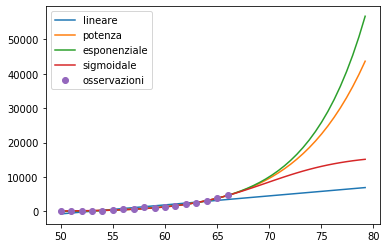

In [4]:
df_x = df_by_datetime['tempo'].values
df_y = df_by_datetime['numero'].values

for mod_name, mod, init_params in all_models_and_initial_params:
    
    model  = Model(mod)
    result = model.fit( df_y, x=df_x, **init_params)
    
    all_year = np.linspace(np.min(df_x), np.max(df_x)*1.2)
    predictions = result.eval(x=all_year)
    plt.plot(all_year, predictions, label=mod_name)
    # print(result.fit_report())   # decommenta questa linea per ottenere le metriche

plt.plot(df_x, df_y, 'o', label='osservazioni')
plt.legend(loc='best')
plt.show()